In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle, os
import pandas as pd
import bottleneck as bn

## Load Important Function

In [2]:
class Data:
    def __init__(self, array_list):
        self.array_list = array_list

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.array_list, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            array_list = pickle.load(f)
        return cls(array_list)

In [3]:
def omega2cistrans(omega):
    """Converts a sequence of float omega angles (in degrees) to an array of ints: 0 cis and 1 trans."""
    
    shifted_omega = (omega + 90.0) % 360.0 - 90.0 # shift into (-90, 270) range to avoid periodic boundaries
    
    cistrans = np.where(shifted_omega > 90.0, 1, 0).astype(int)
    return cistrans

In [4]:
import numpy as np
from tqdm import tqdm

def calculate_conform_p(trajs, conform_num):
    """
    Calculates the cumulative average population of each conformational state over time,
    excluding NaN values in the trajectory.

    Parameters
    ----------
    trajs : np.ndarray
        A 1D array of shape (timesteps,), where each value is either an integer in 
        [0, conform_num-1] or NaN (for missing data).

    conform_num : int
        The total number of conformational states.

    Returns
    -------
    conform_population : np.ndarray
        Array of shape (conform_num, valid_timesteps) — cumulative average population per conformation.
    """
    trajs = np.asarray(trajs)

    # Only keep valid time steps (non-NaN)
    valid_mask = ~np.isnan(trajs)
    trajs_clean = trajs[valid_mask]
    n_time = trajs_clean.shape[0]

    conform_population = np.zeros((conform_num, n_time), dtype=float)

    for conform_state in range(conform_num):
        match_mask = (trajs_clean == conform_state).astype(float)  # shape: (n_time,)

        cumulative_counts = np.cumsum(match_mask)  # shape: (n_time,)
        time_steps = np.arange(1, n_time + 1)      # shape: (n_time,)

        cumulative_proportions = cumulative_counts / time_steps  # shape: (n_time,)
        conform_population[conform_state] = cumulative_proportions

    #print('Conform population shape:', conform_population.shape)

    return conform_population


## Plot the trans population plot

### Load in the omega angle trajectories by result

In [5]:
# Parameters
residues_to_plot = [0, 1, 2]  # Residues to plot
num_residues = len(residues_to_plot)

omegas_by_result = []  # To store processed omega data
save_dir = 'omega_data'
all_omega = Data.load(f"{save_dir}/data.pkl").array_list  # This is an (742, x, 3) array


In [6]:
print(len(all_omega)) 

all_omega[0].shape
all_omega[0]

842


array([[   0.83861196,  -14.872943  ,    7.2696185 ],
       [ -15.203701  ,   20.326454  ,  -13.589486  ],
       [ -22.909151  ,   31.408817  ,    5.943763  ],
       ...,
       [-174.01523   , -159.77078   ,    6.4231105 ],
       [-165.69098   ,  177.86435   ,    5.978243  ],
       [-155.33615   , -168.63237   ,   34.37562   ]], dtype=float32)

### Convert the Omega into 1 trans and 0 cis


In [10]:
ntraj = len(all_omega)
all_cistrans = []
for i in range(ntraj):
    all_cistrans.append(omega2cistrans(all_omega[i]))

all_cistrans

# Find the longest traj
maxlength = max( [ len(all_cistrans[i]) for i in range(ntraj) ])
print('maxlength', maxlength)

# Make an array to store all the trajectories
traj = np.nan * np.ones( (ntraj, maxlength, 3) )

for i in range(ntraj):
    n = len(all_cistrans[i])
    traj[i, 0:n, :] = all_cistrans[i]

traj.shape

maxlength 492298


(842, 492298, 3)

In [11]:
res_num = 3
res_all_traj = []
for res in range(res_num):
    res_traj = traj[:, :, res]
    res_all_traj.append(res_traj)

res_all_traj = np.array(res_all_traj)
print('res_all_traj.shape', res_all_traj.shape)
res_all_traj[0][1]


res_all_traj.shape (3, 842, 492298)


array([ 0.,  0.,  0., ..., nan, nan, nan])

(0.0, 0.3)

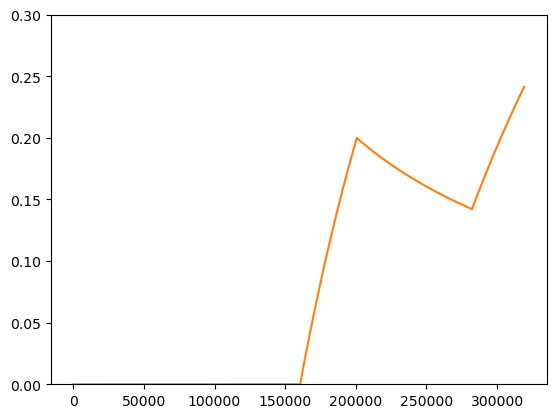

In [12]:
res_all_traj[1][1].shape
conform_num = 2
conform_p = calculate_conform_p(res_all_traj[1][1], conform_num)

plt.plot(conform_p.T)
plt.ylim(0, 0.3)

## Calculate population over time 


In [13]:
df_stationary_p = pd.read_csv("autocoorel_data/trans_population_at_lagtime.csv")
df_stationary_p['state'] = 0  # or whatever state index it should be
print(df_stationary_p)
    
# Pivot the DataFrame to reshape it
pivot_mean = df_stationary_p.pivot(index='state', columns='res', values='mean')
pivot_std = df_stationary_p.pivot(index='state', columns='res', values='std')

# Convert to NumPy arrays
trans_refer = pivot_mean.to_numpy()  # shape (1, 3) state, residues 
trans_refer_err = pivot_std.to_numpy()  # shape (1, 3)
trans_refer.shape

   res  lagtime_index  lagtime_ns      mean       std  state
0    0              6       201.0  0.723847  0.010731      0
1    1              6       201.0  0.438522  0.048915      0
2    2              6       201.0  0.542281  0.050703      0


(1, 3)

In [ ]:
## Use only 754, make sure the total traj length of 8 conformaiton are rougthly the same 

res_all_traj_filtered = res_all_traj[:, :754, :]
res_all_traj_filtered.shape

(3, 754, 492298)

In [17]:
## Create Population over time for all traj 
conform_num = 2
thermal_num = 1
n_traj = res_all_traj_filtered.shape[1]
res_num = 3

all_conform_p = []
for res in range(res_num):
    res_conform_populations = []
    res_traj_indexed = res_all_traj_filtered[res]

    for i in tqdm(range(n_traj), desc=f"Processing all trajectories for residue {res}"):
        single_traj = res_traj_indexed[i]
        conform_p = calculate_conform_p(single_traj, conform_num)
        res_conform_populations.append(conform_p)

    # Find the longest trajectory (in terms of time steps)
    maxlength = max([cp.shape[1] for cp in res_conform_populations])
    print(f"Residue {res} — Max length: {maxlength}")

    # Stack padded arrays
    res_conform_p = np.full((n_traj, conform_num, maxlength), np.nan)
    for i in range(n_traj):
        time_len = res_conform_populations[i].shape[1]
        res_conform_p[i, :, :time_len] = res_conform_populations[i]
    
    all_conform_p.append(res_conform_p)

Processing all trajectories for residue 0: 100%|██████████| 754/754 [00:03<00:00, 226.99it/s]


Residue 0 — Max length: 492298


Processing all trajectories for residue 1: 100%|██████████| 754/754 [00:03<00:00, 218.25it/s]


Residue 1 — Max length: 492298


Processing all trajectories for residue 2: 100%|██████████| 754/754 [00:03<00:00, 246.26it/s]


Residue 2 — Max length: 492298


In [18]:
## Make a trans only traj for processing

all_conform_p = np.array(all_conform_p)
all_conform_p.shape # (3, 742, 2, 345495)
all_trans_p = all_conform_p[:, :, 1, :]

In [19]:
all_trans_p.shape # (3, 742, 345495)
trans_refer.shape #(1, 3)

trans_refer = trans_refer.reshape(3, 1, 1)

trans_refer

array([[[0.72384659]],

       [[0.43852212]],

       [[0.54228087]]])

In [20]:
# Calculate Mean, std, 
n_traj = res_all_traj.shape[1]
res_num = 3

all_mean_trans_p = np.nanmean(all_trans_p, axis=1)
all_std_trans_p = np.nanstd(all_trans_p, axis=1)

In [21]:
os.makedirs('population_data', exist_ok=True)
population_result = [all_mean_trans_p, all_std_trans_p]
data_instance = Data(population_result)
data_instance.save("population_data/population_res.pkl")

In [22]:
errors = np.abs(all_trans_p - trans_refer) ** 2
all_rmsd_trans_p = np.sqrt(np.nansum(errors, axis=1) / all_trans_p.shape[1])

In [23]:
errors_result = [all_rmsd_trans_p]

data_instance = Data(errors_result)
data_instance.save("population_data/error_res.pkl")

In [24]:
all_mean_trans_p, all_std_trans_p = Data.load("population_data/population_res.pkl").array_list
all_mean_trans_p.shape
all_rmsd_trans_p = Data.load("population_data/error_res.pkl").array_list
all_rmsd_trans_p = np.array(all_rmsd_trans_p)
all_rmsd_trans_p = np.squeeze(all_rmsd_trans_p)

## Plot the Ref

In [25]:
df_stationary_p = pd.read_csv("autocoorel_data/trans_population_at_lagtime.csv")
df_stationary_p['state'] = 0  # or whatever state index it should be
print(df_stationary_p)
    
# Pivot the DataFrame to reshape it
pivot_mean = df_stationary_p.pivot(index='state', columns='res', values='mean')
pivot_std = df_stationary_p.pivot(index='state', columns='res', values='std')

# Convert to NumPy arrays
trans_refer = pivot_mean.to_numpy()  # shape (1, 3) state, residues 
trans_refer_err = pivot_std.to_numpy()  # shape (1, 3)
trans_refer.shape
trans_refer

   res  lagtime_index  lagtime_ns      mean       std  state
0    0              6       201.0  0.723847  0.010731      0
1    1              6       201.0  0.438522  0.048915      0
2    2              6       201.0  0.542281  0.050703      0


array([[0.72384659, 0.43852212, 0.54228087]])

In [26]:
trans_refer = trans_refer.reshape(3, 1)
trans_refer_err = trans_refer_err.reshape(3, 1)

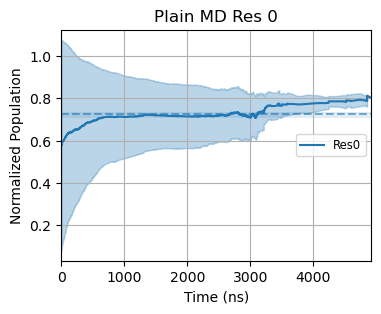

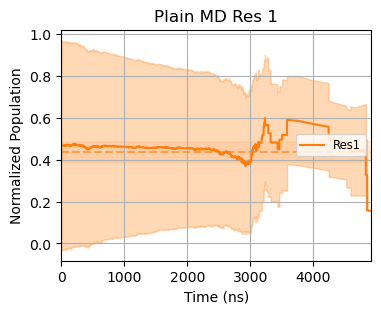

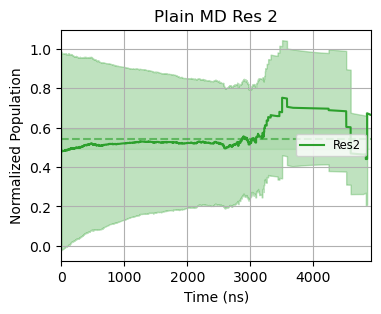

In [27]:
dt_in_ns = 0.01  # 10 ps = 0.01 ns
res_num = 3

for res in range(res_num):
    time = np.arange(all_mean_trans_p.shape[1])
    time_ns = time * dt_in_ns  # Convert to nanoseconds
    plt.figure(figsize=(4, 3))

    mean = all_mean_trans_p[res]
    std = all_std_trans_p[res]

    # Plot and capture the line object to get the color
    line, = plt.plot(time_ns, mean, label=f'Res{res}', color=f'C{res}')
    plt.fill_between(time_ns, mean - std, mean + std, alpha=0.3, color=f'C{res}')
    
    # Reference horizontal line
    ref_y = trans_refer[res]
    ref_yerr = trans_refer_err[res]

    plt.axhline(y=ref_y, linestyle='--', color=f'C{res}', alpha=0.6)
    plt.fill_between(time_ns, ref_y - ref_yerr, ref_y + ref_yerr, color=f'C{res}', alpha=0.1)

    #plt.ylim(0.4, 0.8)
    plt.xlim(time_ns[0], time_ns[-1])  # Optional but precise
    plt.xlabel("Time (ns)")
    plt.ylabel("Normalized Population")
    plt.title(f'Plain MD Res {res}' )
    plt.legend(loc='right',fontsize='small', ncol=2)
    plt.grid(True)
    #plt.tight_layout()
    plt.show()
    plt.close()


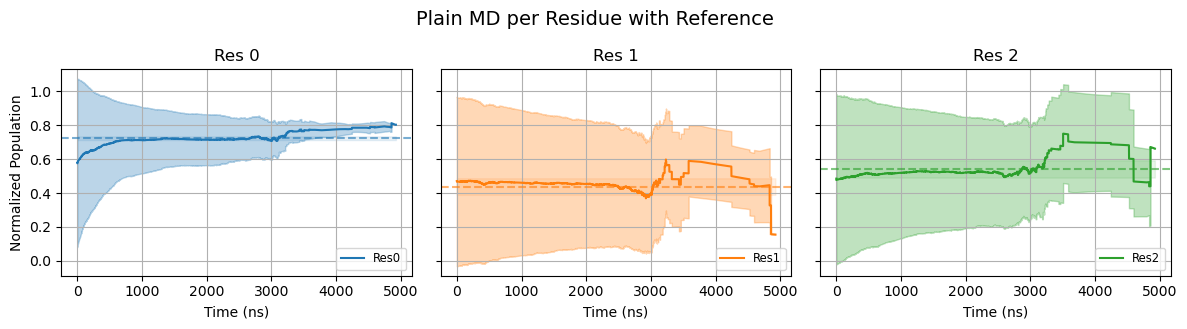

In [28]:
dt_in_ns = 0.01  # 10 ps = 0.01 ns
res_num = 3

time = np.arange(all_mean_trans_p.shape[1])
time_ns = time * dt_in_ns  # Convert to nanoseconds

fig, axes = plt.subplots(1, res_num, figsize=(12, 3), sharex=True, sharey=True)

for res in range(res_num):
    ax = axes[res]

    mean = all_mean_trans_p[res]
    std = all_std_trans_p[res]

    color = f'C{res}'
    ax.plot(time_ns, mean, label=f'Res{res}', color=color)
    ax.fill_between(time_ns, mean - std, mean + std, alpha=0.3, color=color)

    # Reference line and uncertainty
    ref_y = trans_refer[res]
    ref_yerr = trans_refer_err[res]
    ax.axhline(y=ref_y, linestyle='--', color=color, alpha=0.6)
    ax.fill_between(time_ns, ref_y - ref_yerr, ref_y + ref_yerr, color=color, alpha=0.1)

    ax.set_title(f'Res {res}')
    ax.set_xlabel("Time (ns)")
    if res == 0:
        ax.set_ylabel("Normalized Population")
    ax.grid(True)
    ax.legend(loc='lower right', fontsize='small')

plt.tight_layout()
plt.suptitle("Plain MD per Residue with Reference", y=1.08, fontsize=14)
plt.show()


## Plot rmsd over time

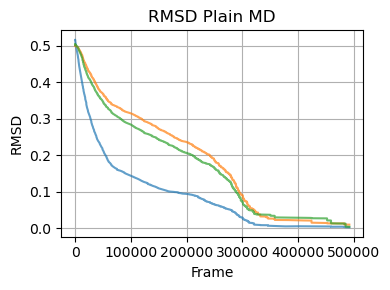

In [29]:
num_to_plot = 10
plt.figure(figsize=(4, 3))
plt.plot(all_rmsd_trans_p.T, alpha=0.7)
plt.xlabel("Frame")
plt.ylabel("RMSD")
plt.title(f"RMSD Plain MD")
plt.grid(True)
plt.tight_layout()
plt.show()
